<a href="https://colab.research.google.com/github/DPariser/DataScience/blob/main/Preprocessing/041823_DNP1_QC_and_Pre_Processing_FASTQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-cell RNA-seq data processing
** Information found in publication: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7857060/

Single-cell sequencing data were aligned and quantified using kallisto/bustools (KB, v0.24.4) (Bray et al., 2016 [link text](https://www.nature.com/articles/nbt.3519)) against the GRCh38 human reference genome downloaded from 10x Genomics official website. Preliminary counts were then used for downstream analysis. Quality control was applied to cells based on three metrics step by step: the total UMI counts, number of detected genes and proportion of mitochondrial gene counts per cell. Specifically, cells with less than 1000 UMI counts and 500 detected genes were filtered, as well as cells with more than 10% mitochondrial gene counts. To remove potential doublets, for PBMC samples, cells with UMI counts above 25,000 and detected genes above 5,000 are filtered out. For other tissues, cells with UMI counts above
70,000 and detected genes above 7,500 are filtered out. Additionally, we applied Scrublet (Wolock et al., 2019 [link text](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6625319/pdf/nihms-1515604.pdf)) to identify potential
doublets. The doublet score for each single cell and the threshold based on the bimodal distribution was calculated using default
parameters. The expected doublet rate was set to be 0.08, and cells predicted to be doublets or with doubletScore larger than  0.25 were filtered. After quality control, a total of 1,598,708 cells were remained. The stepwise quality control metrics used for indi-
vidual samples were listed in Table S1. The resulting distribution of UMI counts, gene counts as well as mitochondrial gene percent-
age were shown in Figures S1C–S1E. We normalized the UMI counts with the deconvolution strategy implemented in the R package scran. Specifically, cell-specific size factors were computed by computeSumFactors function and further used to scale the counts for
each cell. Then the logarithmic normalized counts were used for the downstream analysis.


# Setup Environment

This Notebook is created fresh with nothing else installed explicitly besides what is shown. So we assume that if you follow the instruction exactly, it should run out of the box.

In [15]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

In [16]:
# These packages are pre-installed on Google Colab, but are included here to simplify running this notebook locally
%%capture
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
!pip install scanpy
!pip install anndata

In [17]:
# Install packages for analysis and plotting
from scipy.io import mmread
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scanpy as sc
import anndata

from scipy.sparse import csr_matrix
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.figure_format = 'retina'

## Install kb

Tutorials & Notebooks
* https://www.kallistobus.tools/tutorials/kb_quality_control/python/kb_intro_1_python/
* https://github.com/pachterlab/kallisto-transcriptome-indices
* https://docs.google.com/presentation/d/1QUmi1Mm5dJ1UyQIT_5XAG9806XL4qGfb3OUDrlIvIqs/edit#slide=id.gef29e9d7dc_1_82

In [18]:
%%time
%%capture
# `kb` is a wrapper for the kallisto and bustools program, and the kb-python package contains the kallisto and bustools executables.
!pip install kb-python==0.24.1

CPU times: user 22 ms, sys: 1.87 ms, total: 23.9 ms
Wall time: 3.31 s


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ❗**Connect to the Data**

The data is stored on a shared location in Google Drive. Since many of the files are very large and thus it is not feasable to download them to a location and use them. One good way of dealing with this situation is to create a shortcut to your own Google Drive and point to the shortcut and use them just like they are your own files on Google Drive. Here is the instruction how to set this up.

* Click on the link to the share location of the data.
* Nevigate to the "Data files" folder.
* Click on the "Dropdown" arrow right next to the breaksrumb on the top right.
* Choose "Add shortcut to Drive".

Now it should appear in your Google Drive as the "Data files" folder.
You can now connect to your Google Drive and access the file.
From this point on, we assume that you have the Google Drive setup this way.

Let's mount the Google Drive:



In [20]:
# Google drive root
gd_root = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics"

# Data roots
patient_root = f"{gd_root}/H17_LungMk/Data_files/HRA001149/HRR339729"
lungmk_root = f"{gd_root}/H17_LungMk/LungMk"

# Working directories
patient_dir = f"{patient_root}"
lungmk_dir = f"{lungmk_root}"

# Create the directories if they don't exist
!mkdir -p "{patient_dir}"
!mkdir -p "{lungmk_dir}"

# List the contents of the directories
print("Contents of patient directory:")
!ls "{patient_dir}"
print("\nContents of LungMk directory:")
!ls "{lungmk_dir}"

Contents of patient directory:
HRR339729_f1.fastq.gz  HRR339729_r2.fastq.gz  HRR339729_sta.xml

Contents of LungMk directory:
10xv2_whitelist.txt  inspect.json	    run_info.json
counts_unfiltered    matrix.ec		    t2g.txt
GRCh38genome.idx     output.bus		    transcripts.txt
index.idx	     output.unfiltered.bus  v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


In [21]:
# Check if the directories exist
if os.path.exists(lungmk_dir):
    print(f"The directory {lungmk_dir} exists.")
else:
    print(f"The directory {lungmk_dir} does not exist.")

if os.path.exists(patient_dir):
    print(f"The directory {patient_dir} exists.")
else:
    print(f"The directory {patient_dir} does not exist.")

The directory /content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/LungMk exists.
The directory /content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149/HRR339729 exists.


# Prepare for quantification for GRCh38

GRCh38 stands for Genome Reference Consortium Human Build 38, which is the most recent version of the human reference genome. It is a widely used reference genome for human genetics and genomics research, and provides a standardized framework for comparing and interpreting genomic data across studies. The GRCh38 assembly was released in December 2013 and contains more than 3 billion base pairs, representing the genetic information of a complete set of human chromosomes. It includes both coding and non-coding regions of the genome and is used as a reference for many different applications, such as genome sequencing, variant calling, and gene expression analysis.

Here we are downloading two files that enable us to process the FastQ files we **have**:

1. The index file: this is a k-mer index built from a reference transcriptome. It is a binary file that contains information on the position of each k-mer within the transcriptome, which is used to map the reads to the transcriptome during the quantification step. The index file is generated by a software tool such as kallisto or salmon using a reference transcriptome in FASTA format. 
2. The t2g file: this is a file that maps each transcript to a corresponding gene. This mapping is necessary because RNA sequencing reads can align to either a specific transcript or a gene, and the counts for each transcript need to be aggregated to obtain gene-level expression. The t2g file can be used to generate gene-level counts from transcript-level counts.

## Download the index and t2g files

The code downloads reference files to a temporary directory, extracts them, and moves them to a working directory. The importance of this step is that the extracted files are necessary for downstream analysis, such as quantification of RNA-seq data using Kallisto.

In [22]:
%%time
# Create a temporary directory
!mkdir -p tmp

# Download the reference files to a temporary directory
!kb ref -d human -i tmp/index.idx -g tmp/t2g.txt -f1 tmp/transcriptome.fa --keep-tmp

# Move the extracted files to the LungMk directory
!mv tmp/* "{lungmk_dir}"

# Remove the temporary directory
!rm -r tmp

# Inspect the index files to ensure that they were downloaded properly
index_idx_size = os.path.getsize(f"{lungmk_dir}/index.idx") / (1024*1024*1024)
t2g_size = os.path.getsize(f"{lungmk_dir}/t2g.txt") / (1024*1024*1024)

print(f"index.idx size: {index_idx_size:.2f} GB")
print(f"t2g.txt size: {t2g_size:.2f} GB")
!ls "{lungmk_dir}"

[2023-04-28 19:25:17,444]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
[2023-04-28 19:29:34,306]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
index.idx size: 2.93 GB
t2g.txt size: 0.01 GB
10xv2_whitelist.txt  inspect.json	    run_info.json
counts_unfiltered    matrix.ec		    t2g.txt
GRCh38genome.idx     output.bus		    transcripts.txt
index.idx	     output.unfiltered.bus  v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
CPU times: user 1.39 s, sys: 240 ms, total: 1.63 s
Wall time: 5min 12s


## One Patient File 

The code block below is important for counting and quantifying RNA-seq data in a specific patient's sample using the Kallisto and bustools packages. The code inspects the first few lines of a file, downloads an index file generated from the reference transcriptome sequences in FASTA format, and uses it to perform the count of RNA molecules, transcripts, and genes. The resulting data will be used for downstream analysis and to gain insight into the transcriptional landscape of the patient's sample. The code in cells under "looping" will loop through all patient files to count and quantify RNA-seq data.

In [26]:
%%time
# Kallisto index files are binary files. They are generated from the reference transcriptome sequences in FASTA format,
# and the resulting index file is used to perform fast and memory-efficient quantification of RNA-seq data.

# Inspect the first few lines of the files
!head "{lungmk_dir}/t2g.txt"

# (...)
platform = "10X 3'"

if platform == "10X 3'":
    x_parameter = "10xv2"
elif platform == "10X 5'":
    x_parameter = "10xv3"

!kb count -o {patient_dir} -i {lungmk_dir}/index.idx -g {lungmk_dir}/t2g.txt --overwrite -t 2 -x {x_parameter} {patient_dir}/HRR339729_f1.fastq.gz {patient_dir}/HRR339729_r2.fastq.gz

ENST00000456328.2	ENSG00000223972.5	DDX11L1
ENST00000450305.2	ENSG00000223972.5	DDX11L1
ENST00000488147.1	ENSG00000227232.5	WASH7P
ENST00000619216.1	ENSG00000278267.1	MIR6859-1
ENST00000473358.1	ENSG00000243485.5	MIR1302-2HG
ENST00000469289.1	ENSG00000243485.5	MIR1302-2HG
ENST00000607096.1	ENSG00000284332.1	MIR1302-2
ENST00000417324.1	ENSG00000237613.2	FAM138A
ENST00000461467.1	ENSG00000237613.2	FAM138A
ENST00000606857.1	ENSG00000268020.3	OR4G4P
[2023-04-28 20:23:28,685]    INFO Generating BUS file from
[2023-04-28 20:23:28,685]    INFO         /content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149/HRR339729/HRR339729_f1.fastq.gz
[2023-04-28 20:23:28,685]    INFO         /content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149/HRR339729/HRR339729_r2.fastq.gz
[2023-04-28 20:58:24,878]    INFO Sorting BUS file /content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149/HRR339729/output.bus to tmp/output.s.bus
[2

In [27]:
!ls "{patient_dir}"

10xv2_whitelist.txt    HRR339729_sta.xml  output.unfiltered.bus
counts_unfiltered      inspect.json	  run_info.json
HRR339729_f1.fastq.gz  matrix.ec	  transcripts.txt
HRR339729_r2.fastq.gz  output.bus


# Looping for all patient files

Looking for all patients

In [ ]:
%%time
# Identify all the patients so we can loop through them in the cell below
folder_path = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149"

# List the directories in the folder
directories = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

# Print the directories
print(directories)

# Use the directories as patient_ids
patient_ids = directories

for patient_id in patient_ids:
    patient_root = f"{gd_root}/H17_LungMk/Data_files/HRA001149/{patient_id}"
    patient_dir = f"{patient_root}"
    
    # Create the directory if it doesn't exist
    !mkdir -p "{patient_dir}"
    
    # Check if the directory exists
    if os.path.exists(patient_dir):
        print(f"The directory {patient_dir} exists.")
    else:
        print(f"The directory {patient_dir} does not exist.")
    
    # Check if the BUS file exists
    bus_file = f"{patient_dir}/output.bus"
    if os.path.exists(bus_file):
        print(f"BUS file for patient {patient_id} already exists. Skipping.")
        continue
    
    # Kallisto count command
    !kb count -o {patient_dir} -i {lungmk_dir}/index.idx -g {lungmk_dir}/t2g.txt --overwrite -t 2 -x {x_parameter} {patient_root}/{patient_id}_f1.fastq.gz {patient_root}/{patient_id}_r2.fastq.gz

['HRR339728', 'HRR339729', 'HRR339730', 'HRR339731', 'HRR339732', 'HRR339733', 'HRR339734', 'HRR339735', 'HRR339736', 'HRR339737', 'HRR339738', 'HRR339740', 'HRR339739', 'HRR339741', 'HRR339743', 'HRR339748', 'HRR339753', 'HRR339751', 'HRR339752', 'HRR339755', 'HRR339756', 'HRR339754', 'HRR339749', 'HRR339750', 'HRR339742', 'HRR339746', 'HRR339747', 'HRR339744', 'HRR339759', 'HRR339757', 'HRR339761', 'HRR339760', 'HRR339762', 'HRR339765', 'HRR339764', 'HRR339763', 'HRR339770', 'HRR339769', 'HRR339771', 'HRR339772', 'HRR339775', 'HRR339777', 'HRR339774', 'HRR339776', 'HRR339773', 'HRR339778', 'HRR339786', 'HRR339787', 'HRR339795', 'HRR339766', 'HRR339767', 'HRR339768', 'HRR339790', 'HRR339791', 'HRR339792', 'HRR339789', 'HRR339788', 'HRR339758', 'HRR339794', 'HRR339793', 'HRR339805', 'HRR339801', 'HRR339802', 'HRR339799', 'HRR339804', 'HRR339803', 'HRR339798', 'HRR339797', 'HRR339796', 'HRR339800', 'HRR339808', 'HRR339806', 'HRR339815', 'HRR339812', 'HRR339811', 'HRR339814', 'HRR339807'

In [31]:
# Identify all the patients so we can loop through them in the cell below
#folder_path = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149"

# List the directories in the folder
#directories = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

# Print the directories
#print(directories)

['HRR339728', 'HRR339729', 'HRR339730', 'HRR339731', 'HRR339732', 'HRR339733', 'HRR339734', 'HRR339735', 'HRR339736', 'HRR339737', 'HRR339738', 'HRR339740', 'HRR339739', 'HRR339741', 'HRR339743', 'HRR339748', 'HRR339753', 'HRR339751', 'HRR339752', 'HRR339755', 'HRR339756', 'HRR339754', 'HRR339749', 'HRR339750', 'HRR339742', 'HRR339746', 'HRR339747', 'HRR339744', 'HRR339759', 'HRR339757', 'HRR339761', 'HRR339760', 'HRR339762', 'HRR339765', 'HRR339764', 'HRR339763', 'HRR339770', 'HRR339769', 'HRR339771', 'HRR339772', 'HRR339775', 'HRR339777', 'HRR339774', 'HRR339776', 'HRR339773', 'HRR339778', 'HRR339786', 'HRR339787', 'HRR339795', 'HRR339766', 'HRR339767', 'HRR339768', 'HRR339790', 'HRR339791', 'HRR339792', 'HRR339789', 'HRR339788', 'HRR339758', 'HRR339794', 'HRR339793', 'HRR339805', 'HRR339801', 'HRR339802', 'HRR339799', 'HRR339804', 'HRR339803', 'HRR339798', 'HRR339797', 'HRR339796', 'HRR339800', 'HRR339808', 'HRR339806', 'HRR339815', 'HRR339812', 'HRR339811', 'HRR339814', 'HRR339807'

# Quantification

This step runs `kb` to quantify the reads. `kb` can take as input URLs where the reads are located, and will stream the data to Google Colab where it is quantified as it is downloaded. This allows for quantifying very large datasets without first downloading them and saving them to disk.

In [24]:
# Read in the count matrix that was output by `kb`.
mtx = mmread("/content/counts_unfiltered/cells_x_genes.mtx")

print(mtx.shape)

(81171, 60623)


In [25]:
# Create an instance of TruncatedSVD with 2 components
tsvd = TruncatedSVD(n_components=2)

# Fit the truncated SVD to the sparse matrix
tsvd.fit(mtx)

# Transform the sparse matrix to a 2-dimensional array
X = tsvd.transform(mtx)

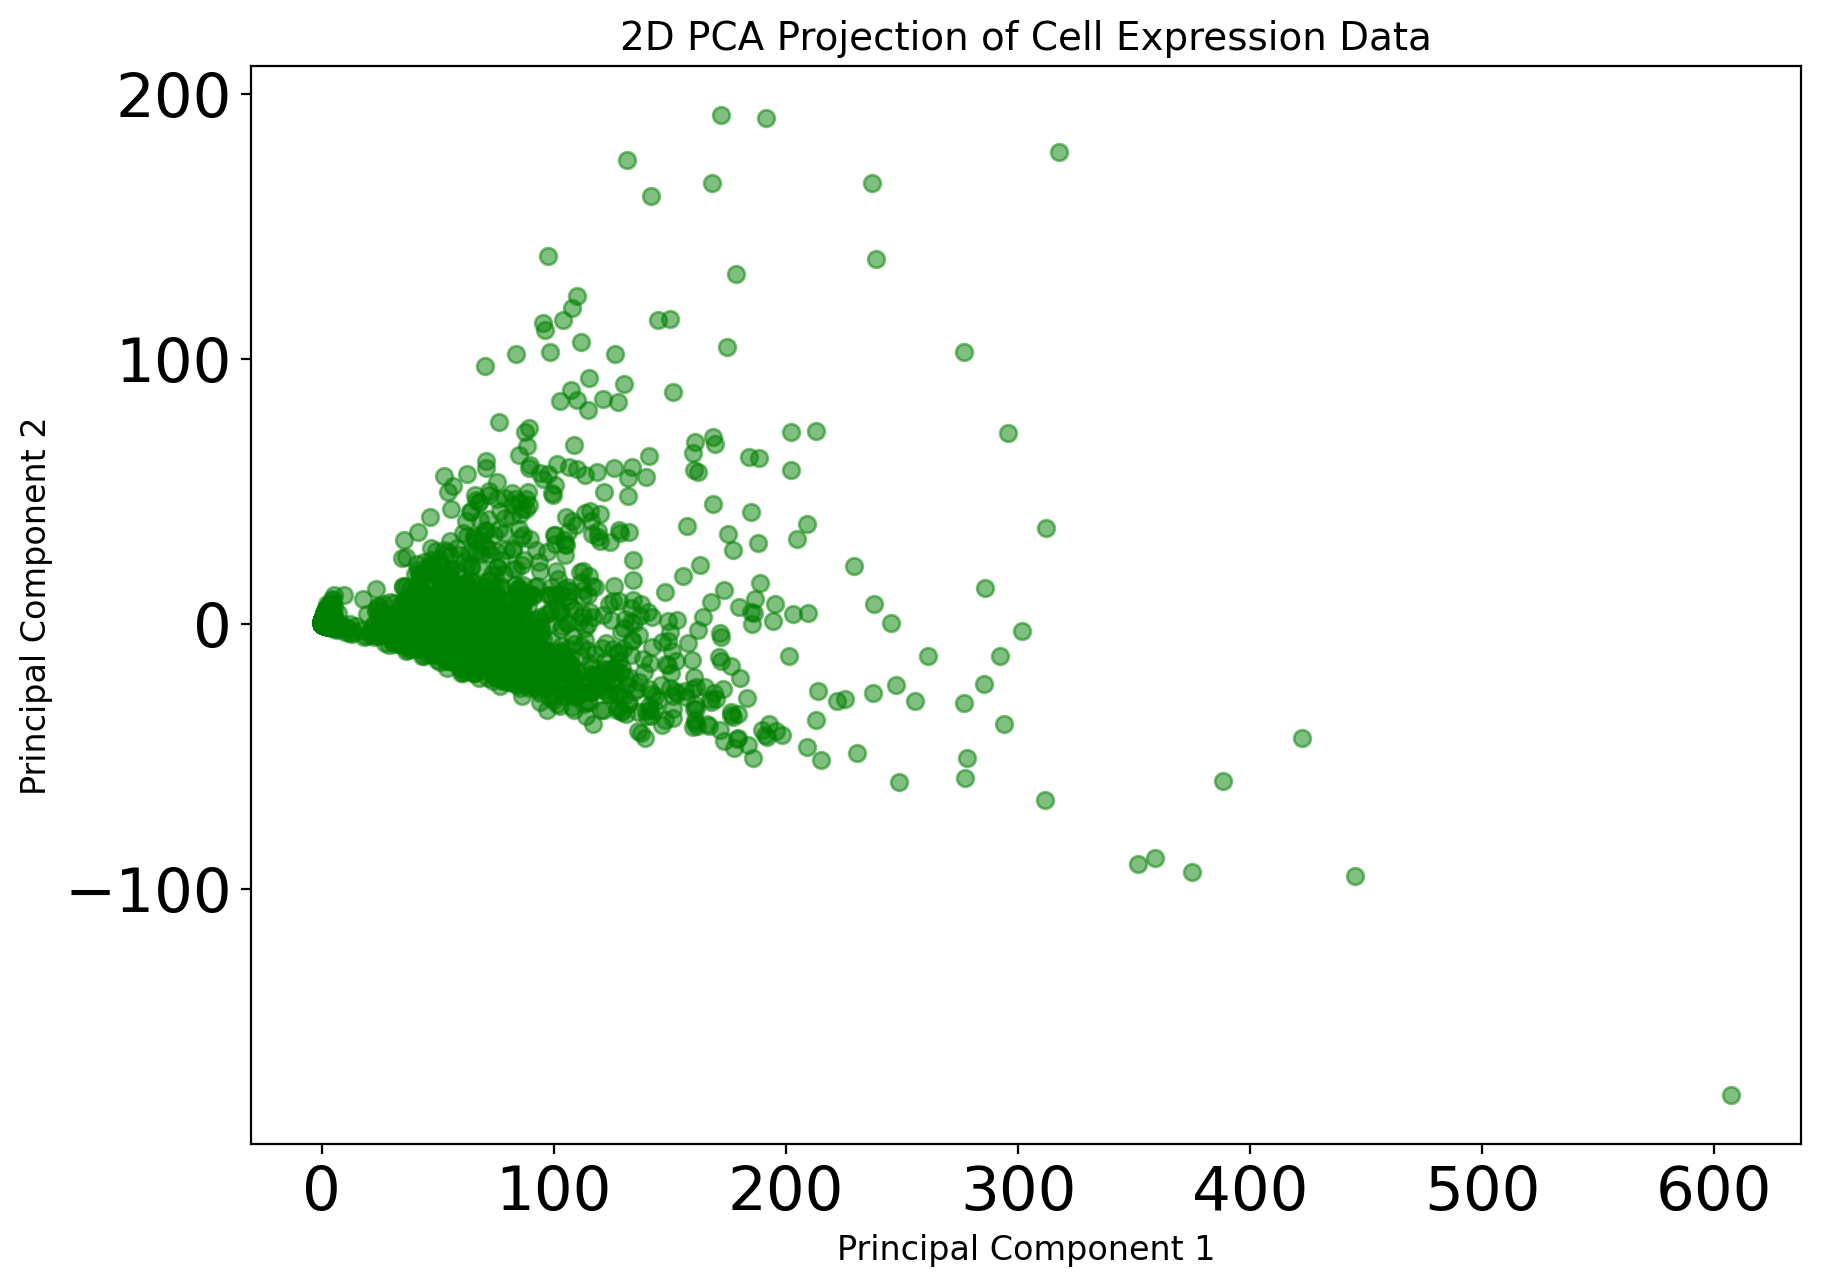

In [28]:
import matplotlib.pyplot as plt

# Define the labels and header text
title = "2D PCA Projection of Cell Expression Data"
x_label = "Principal Component 1"
y_label = "Principal Component 2"

# Create a new figure with a size of 10x7 inches
fig, ax = plt.subplots(figsize=(10, 7))

# Create a scatter plot of the first and second columns of X
# with a transparency of 0.5 and the color green, and add labels
ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")
ax.set_xlabel(x_label, fontsize=12)
ax.set_ylabel(y_label, fontsize=12)

# Set the title and display the plot
ax.set_title(title, fontsize=14)
plt.show()


While the PCA plot shows the overall structure of the data, a visualization highlighting the density of points reveals a large number of droplets represented in the lower left corner.


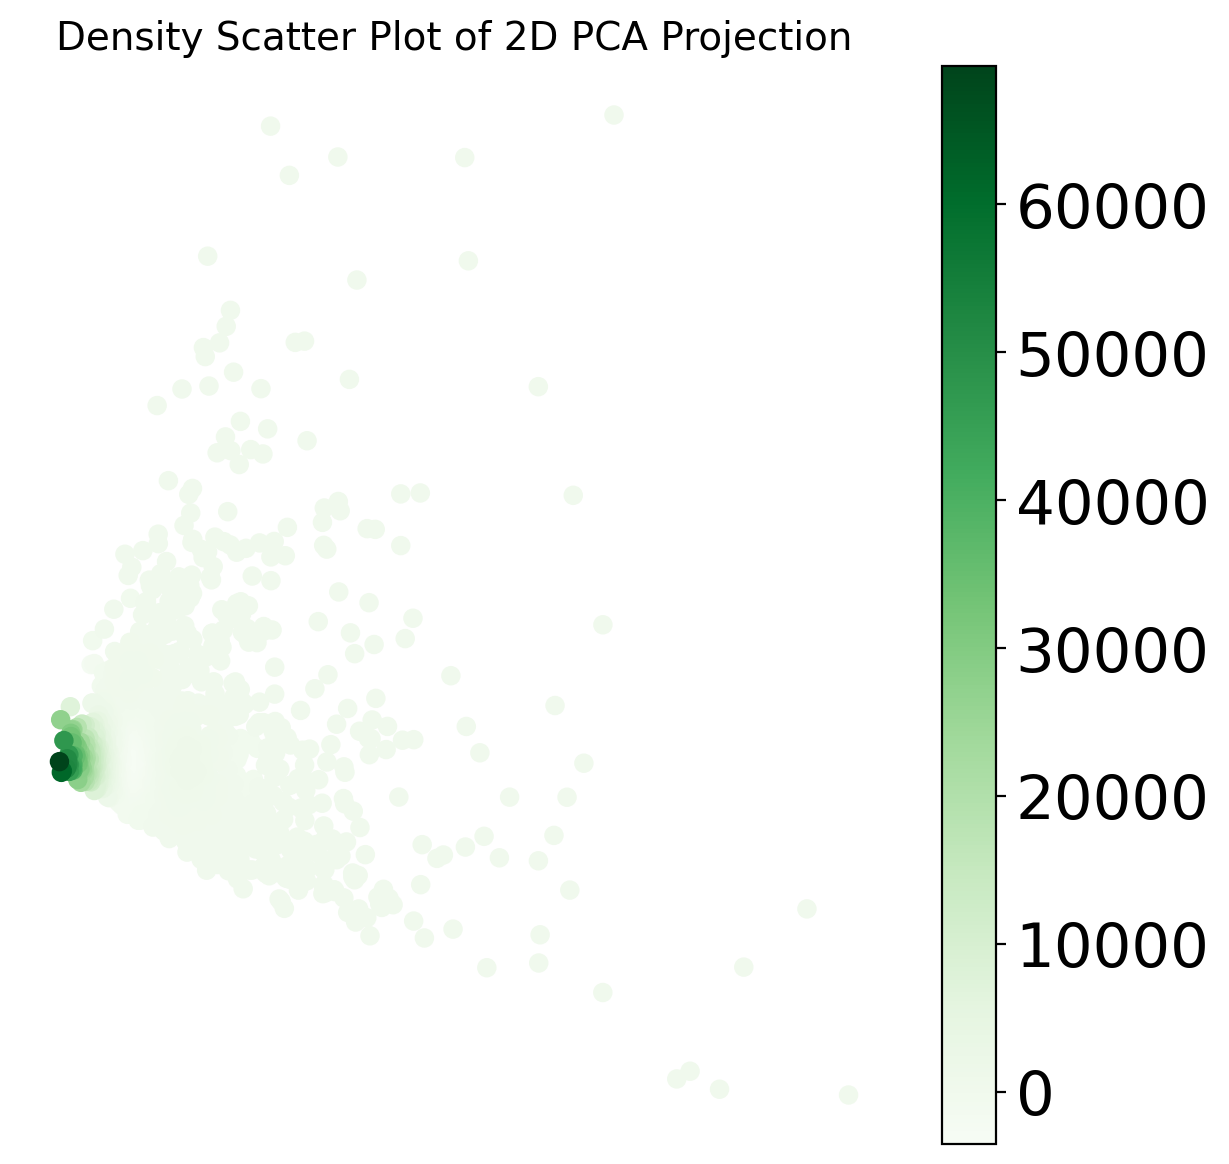

In [30]:
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    sc = ax.scatter( x, y, c=z, **kwargs )
    return sc

# Define the labels and header text
title = "Density Scatter Plot of 2D PCA Projection"
x_label = "Principal Component 1"
y_label = "Principal Component 2"

# Create a new figure with a size of 7x7 inches
fig, ax = plt.subplots(figsize=(7,7))

# Create a density scatter plot of the first and second columns of X
# with a color map of "Greens" and add labels
x = X[:,0]
y = X[:,1]
sc = density_scatter(x, y, ax=ax, cmap="Greens")
ax.set_xlabel(x_label, fontsize=12)
ax.set_ylabel(y_label, fontsize=12)

# Add a colorbar and turn off the axis labels and ticks
fig.colorbar(sc, ax=ax)
plt.axis('off')

# Set the title and display the plot
ax.set_title(title, fontsize=14)
plt.show()


Sparse matrices are commonly used in data analysis and machine learning when dealing with large datasets that have many zeros or missing values. The CSR format is one of the most commonly used sparse matrix formats, as it provides efficient access to both the row and column indices of the non-zero elements, as well as their values.

In [31]:
# Create sparse matrix representation of the count matrix
mtx = csr_matrix(mtx)

### Test for library saturation

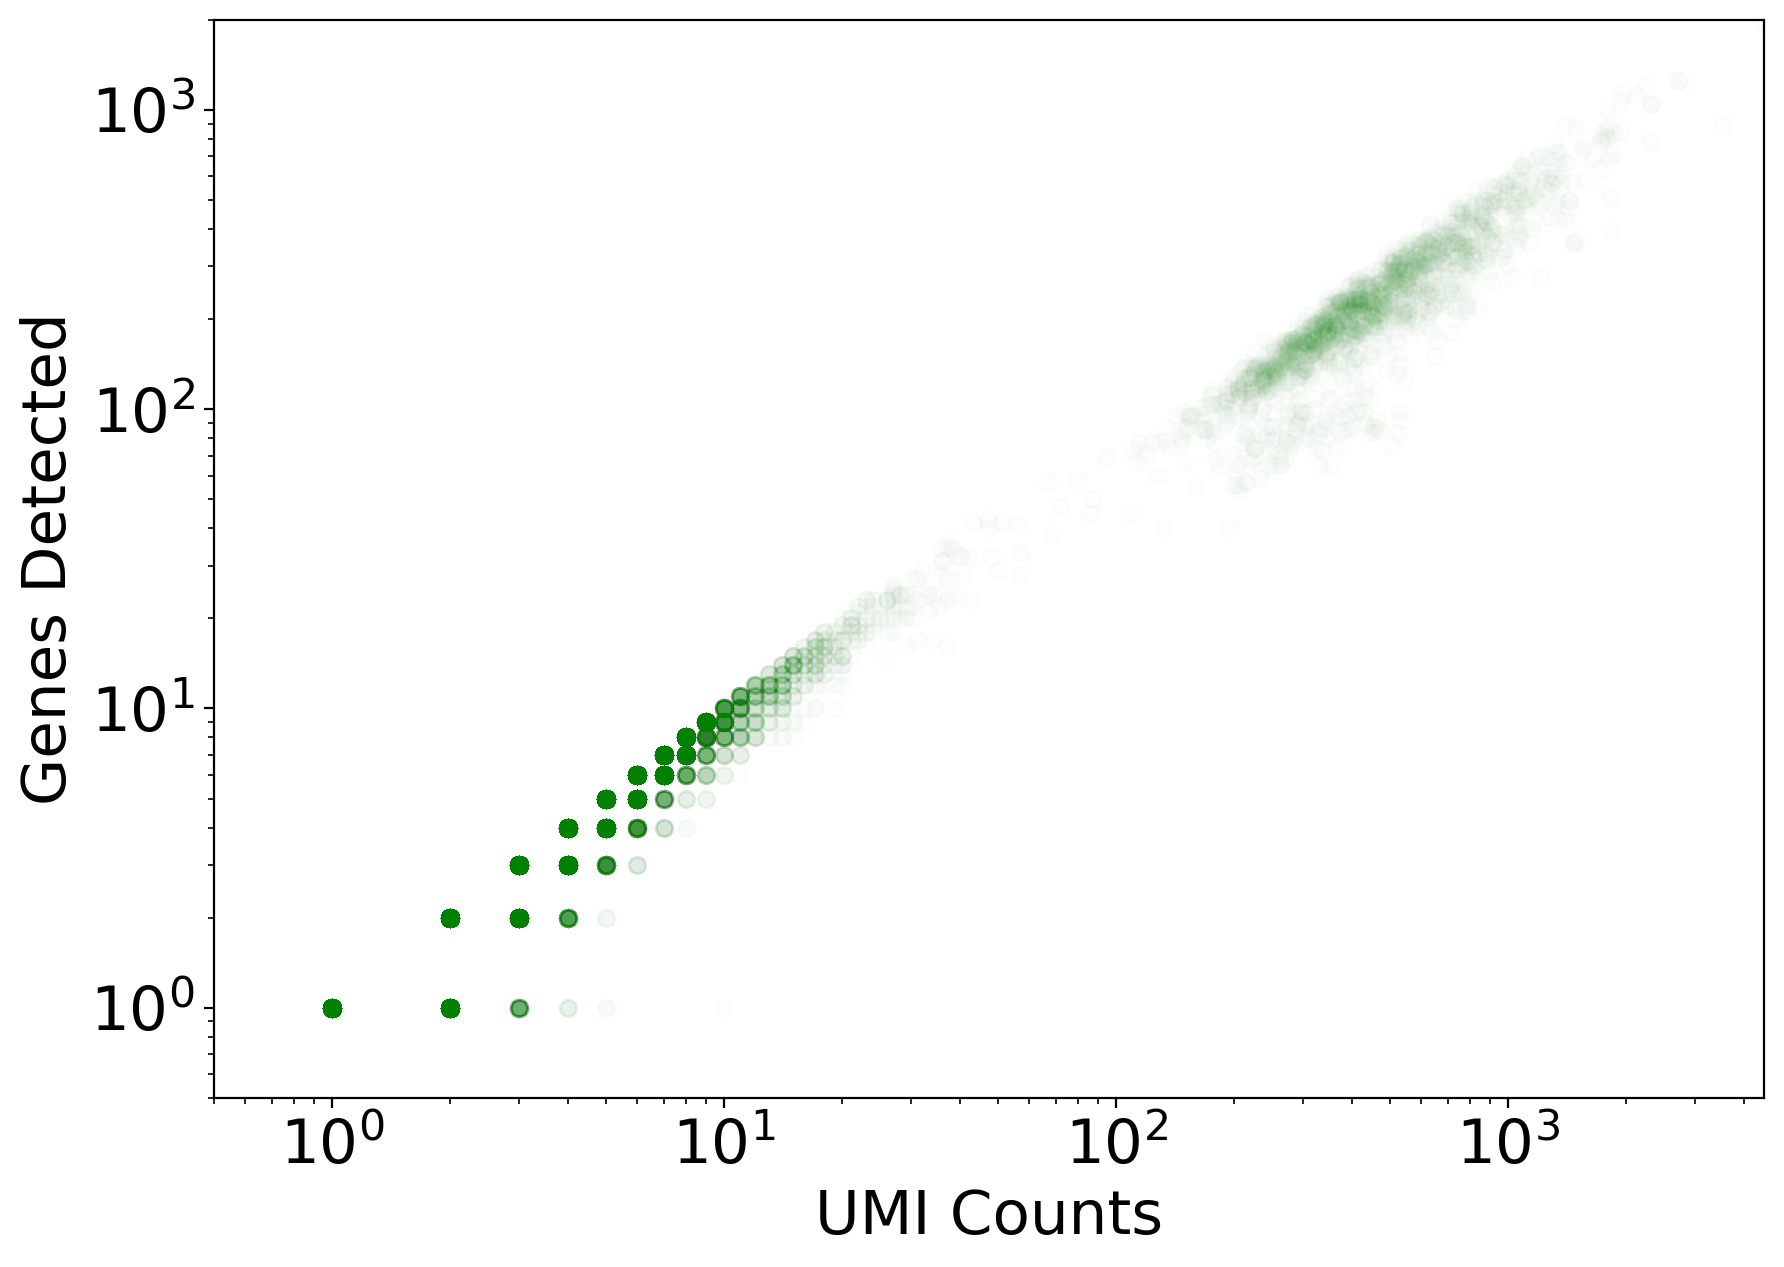

In [34]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1))[:,0], np.asarray(np.sum(mtx>0, axis=1))[:,0], color="green", alpha=0.01)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))

plt.show()

Here we see that there are a large number of near empty droplets. A useful approach to filtering out such data is the "knee plot" shown below.

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

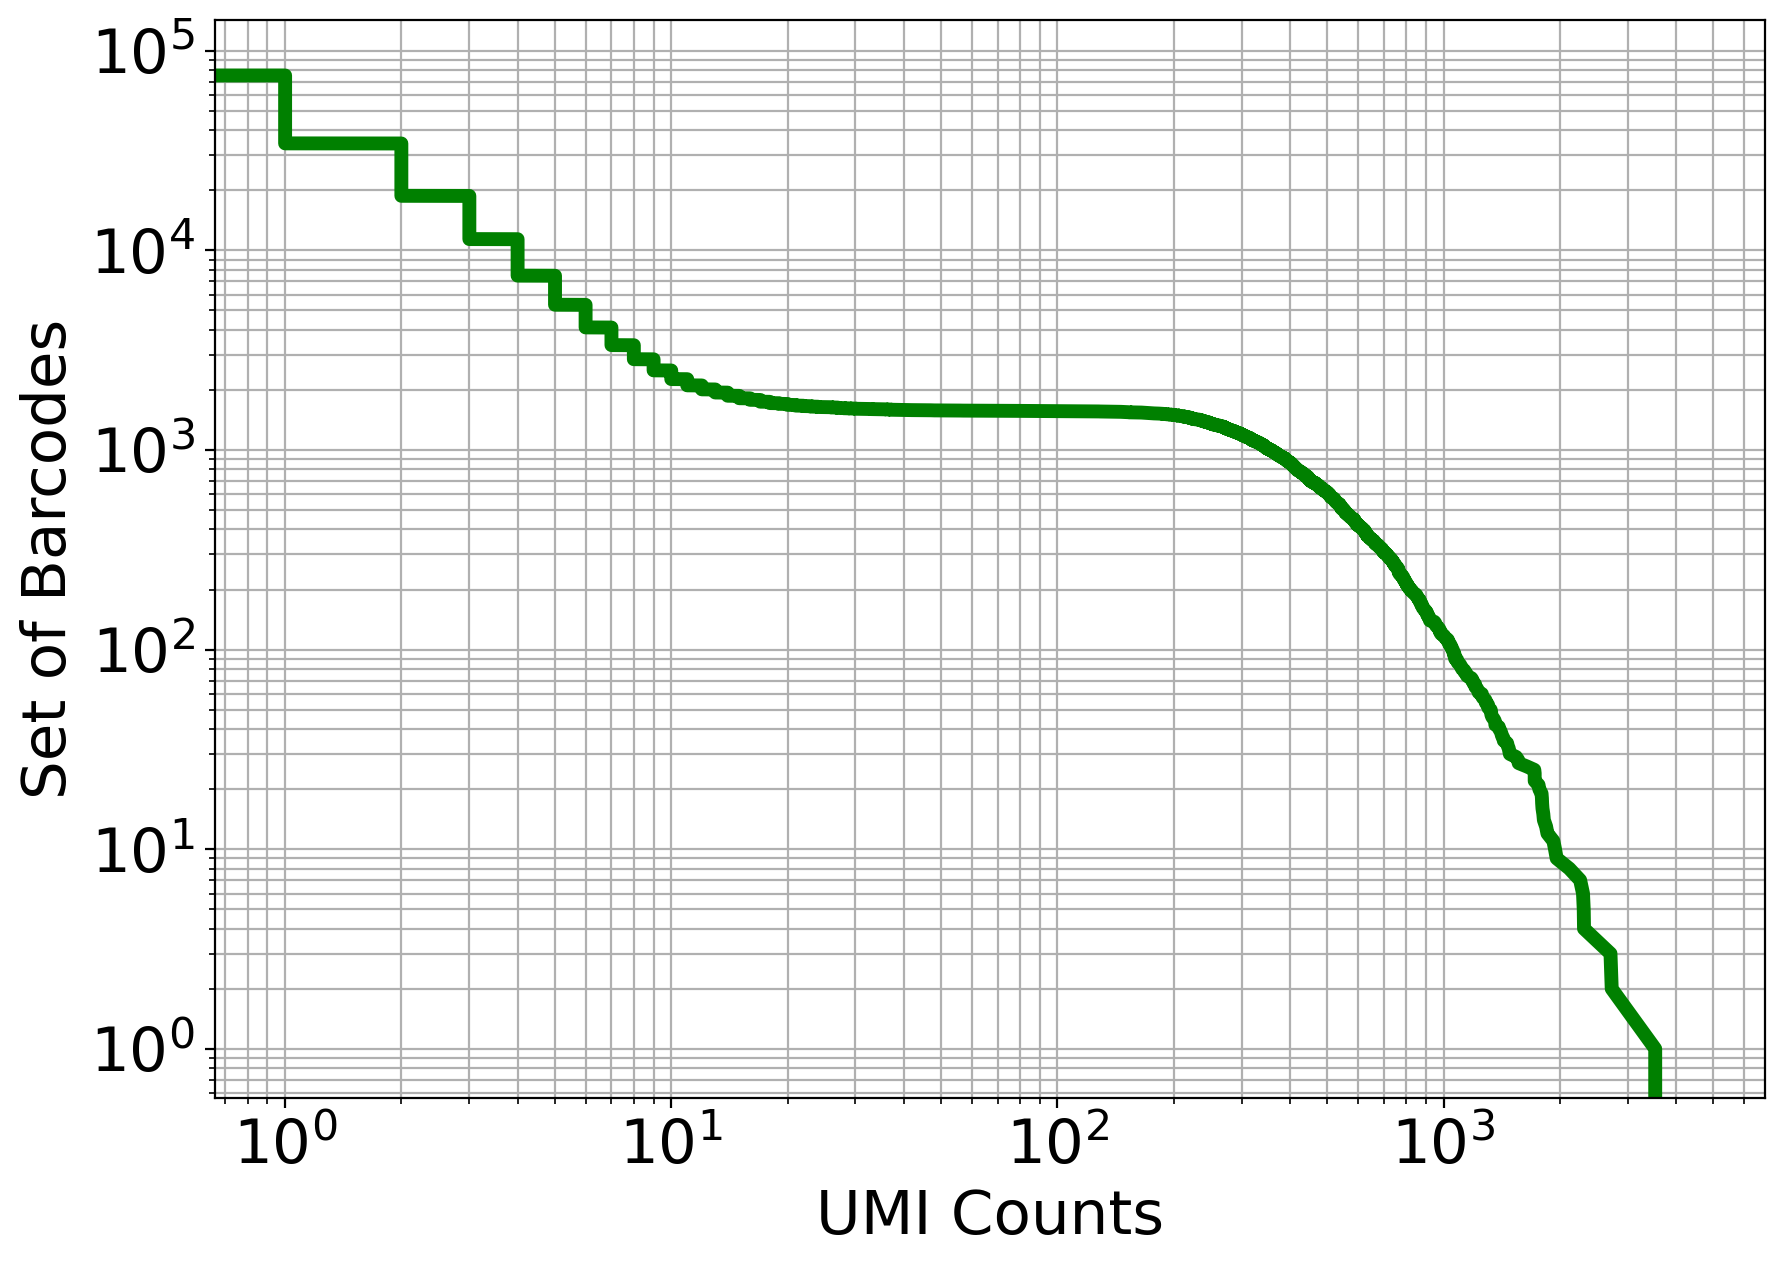

In [35]:
# Create the "knee plot"
knee = np.sort((np.array(mtx.sum(axis=1))).flatten())[::-1]
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)),linewidth=5, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()


The following plot helps clarify the reason for the concentrated points in the lower-left corner of the PCA plot.

In [ ]:
import struct

bus_path = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/LungMk/output.bus"

# Check the number of lines in the output.bus file
num_lines = 0
with open(bus_path, "rb") as f:
    while True:
        binary = f.read(4)
        if not binary:
            break
        (record_size,) = struct.unpack("<I", binary)
        f.read(record_size)
        num_lines += 1

print(f"Number of lines in the output.bus file: {num_lines}")

# Print the first few lines of the output.bus file
with open(bus_path, "rb") as f:
    for i in range(10):
        binary = f.read(4)
        (record_size,) = struct.unpack("<I", binary)
        record = f.read(record_size)
        print(record)


# Quality Control

## need to edit this for looping

* https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/docs/tutorials/kb_getting_started/python/kb_intro_2_python.ipynb

## Filtering cells based on count
Preliminary counts were then used for downstream analysis. Quality control was applied to cells based on three metrics step by step: the total UMI counts, number of detected genes and proportion of mitochondrial gene counts per cell. Specifically, cells with less than 1500 UMI counts and 500 detected genes were filtered, as well as cells with more than 10% mitochondrial gene counts. 

In [ ]:
# Read in the count matrix that was output by `kb`
adata = sc.read_mtx("/content/counts_unfiltered/cells_x_genes.mtx").T

# Read the genes and barcodes
genes = pd.read_csv("/content/counts_unfiltered/cells_x_genes.genes.txt", header=None, names=['ensembl_id'])
barcodes = pd.read_csv("/content/counts_unfiltered/cells_x_genes.barcodes.txt", header=None, names=['barcode'])

# Set the gene and barcode annotations
adata.var = genes
adata.obs = barcodes

In [ ]:
# Normalize the counts and log-transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Filter cells based on UMI counts, number of detected genes, and proportion of mitochondrial gene counts
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=500)

# Identify and filter mitochondrial genes
mito_genes = adata.var_names.str.startswith("MT-")
adata.obs["percent_mito"] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata = adata[adata.obs["percent_mito"] < 0.1, :]

In [ ]:
# Perform PCA
sc.tl.pca(adata)

# Compute the neighborhood graph
sc.pp.neighbors(adata)

# Compute UMAP embedding
sc.tl.umap(adata)

# Cluster cells using the Leiden algorithm
sc.tl.leiden(adata)

# Plot UMAP embedding colored by Leiden clusters
sc.pl.umap(adata, color=["leiden"])

## Remove potential doublets (double balloon effect)

This is what the investigators did in the original paper:


*   To remove potential doublets, for PBMC samples, cells with UMI counts above 25,000 and detected genes above 5,000 are filtered out. For other tissues, cells with UMI counts above 70,000 and detected genes above 7,500 are filtered out. Additionally, we applied Scrublet (Wolock et al., 2019 link text) to identify potential doublets. The doublet score for each single cell and the threshold based on the bimodal distribution was calculated using default parameters. The expected doublet rate was set to be 0.08, and cells predicted to be doublets or with doubletScore larger than 0.25 were filtered. After quality control, a total of 1,598,708 cells were remained.
*   for now we will not be using onliy the PBMC filter methods applied to all tissues
*  *We may revisit this later*

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET

# Load the count matrix
counts = pd.read_csv("/content/drive/MyDrive/Pate Lab/DNP Folder/Bioinformatics/H17 Lung Mk from COVID-19 Patients/LungMk/counts/HRR339729/counts_unfiltered/cells_x_genes.mtx", sep=" ", skiprows=3, header=None)
counts.columns = ["barcode", "gene_id", "UMI"]

# Set the barcode column as the index
counts = counts.pivot(index="barcode", columns="gene_id", values="UMI")

# Load the metadata file from the XML
xml_tree = ET.parse('/content/drive/MyDrive/Pate Lab/DNP Folder/Bioinformatics/H17 Lung Mk from COVID-19 Patients/Data files/HRA001149/HRR339729/HRR339729_sta_new.xml')
root = xml_tree.getroot()
metadata_dict = {}
for child in root.iter():
    metadata_dict[child.tag] = child.text
metadata = pd.DataFrame([metadata_dict])

# Determine the filtering thresholds
umi_threshold = 25000
gene_threshold = 5000

# Compute the UMI counts and number of detected genes for each cell
umi_counts = counts.sum(axis=0)
detected_genes = (counts > 0).sum(axis=0)

# Filter out cells with UMI counts or detected genes above the thresholds
mask = (umi_counts <= umi_threshold) & (detected_genes <= gene_threshold)
filtered_counts = counts.loc[:, mask]

# Print some statistics about the filtering
print("Before filtering:")
print(f"Number of cells: {counts.shape[1]}")
print(f"Max UMI count: {umi_counts.max()}")
print(f"Max detected genes: {detected_genes.max()}")
print("")
print("After filtering:")
print(f"Number of cells: {filtered_counts.shape[1]}")
print(f"Max UMI count: {filtered_counts.sum(axis=0).max()}")
print(f"Max detected genes: {(filtered_counts > 0).sum(axis=0).max()}")


Before filtering:
Number of cells: 1
Max UMI count: 0
Max detected genes: 0

After filtering:
Number of cells: 1
Max UMI count: 0
Max detected genes: 0


In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET

# Load the count matrix
counts = pd.read_csv("output/counts/bus_output/output.bus.count.txt", index_col=0)

# Load the metadata file from the XML
xml_tree = ET.parse('/content/drive/MyDrive/Colab_Notebooks/Lung_Mk/HRR339742/HRR339742_sta.xml')
root = xml_tree.getroot()
metadata_dict = {}
for child in root.iter():
    metadata_dict[child.tag] = child.text
metadata = pd.DataFrame([metadata_dict])

# Determine the filtering thresholds
umi_threshold = 25000
gene_threshold = 5000

# Compute the UMI counts and number of detected genes for each cell
umi_counts = counts.sum(axis=0)
detected_genes = (counts > 0).sum(axis=0)

# Filter out cells with UMI counts or detected genes above the thresholds
mask = (umi_counts <= umi_threshold) & (detected_genes <= gene_threshold)
filtered_counts = counts.loc[:, mask]

# Print some statistics about the filtering
print("Before filtering:")
print(f"Number of cells: {counts.shape[1]}")
print(f"Max UMI count: {umi_counts.max()}")
print(f"Max detected genes: {detected_genes.max()}")
print("")
print("After filtering:")
print(f"Number of cells: {filtered_counts.shape[1]}")
print(f"Max UMI count: {filtered_counts.sum(axis=0).max()}")
print(f"Max detected genes: {(filtered_counts > 0).sum(axis=0).max()}")

## Data visualization

The stepwise quality control metrics used for individual samples were listed in Table S1. The resulting distribution of UMI counts, gene counts as well as mitochondrial gene percent- age were shown in Figures S1C–S1E. 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the count matrix
counts = pd.read_csv("output/counts/bus_output/output.bus.count.txt", sep="\t", index_col=0)

# Load the gene annotation file from the metadata XML
metadata = pd.read_xml("/content/drive/MyDrive/Colab_Notebooks/Lung_Mk/HRR339742/HRR339742_sta.xml")
genes = pd.DataFrame(metadata["transcript"].apply(lambda x: x.get("gene_name")).unique(), columns=["gene_name"])

# Identify mitochondrial genes
mito_genes = genes[genes["gene_name"].str.startswith("MT-")].index
mito_counts = counts.loc[mito_genes].sum(axis=0)
total_counts = counts.sum(axis=0)
mito_percentage = mito_counts / total_counts * 100

# Compute the UMI counts and number of detected genes for each cell
umi_counts = counts.sum(axis=0)
detected_genes = (counts > 0).sum(axis=0)

# Plot the distribution of UMI counts, detected genes, and mitochondrial gene percentage
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
sns.histplot(umi_counts, ax=axes[0])
sns.histplot(detected_genes, ax=axes[1])
sns.histplot(mito_percentage, ax=axes[2])
axes[0].set_xlabel("UMI counts")
axes[1].set_xlabel("Number of detected genes")
axes[2].set_xlabel("Mitochondrial gene percentage")
plt.show()

# before and after plots

## Normaliazed UMI counts

This is what the paper did:

*  We normalized the UMI counts with the deconvolution strategy implemented in the  R package scran. Specifically, cell-specific size factors were computed by computeSumFactors function and further used to scale the counts for each cell. Then the logarithmic normalized counts were used for the downstream analysis.
*  We can use Scnapy instead

In [ ]:
import scanpy as sc

# Load the count matrix
adata = sc.read_text("output/counts/bus_output/output.bus.count.txt", delimiter="\t").T

# Normalize the data using Total Count Normalization (TCN)
sc.pp.normalize_total(adata, target_sum=1e4)

# Scale the data by cell-specific size factors
sc.pp.scale(adata, max_value=10)

# Logarithmically transform the data
sc.pp.log1p(adata)

For normalization of UMI counts, the Scanpy package provides several normalization methods, including the Total Count Normalization (TCN) and Normalization by Logarithm (LogNormalize) methods, which are commonly used in single-cell RNA-seq analysis. Here, we first load the count matrix using Scanpy's read_text function. We then normalize the data using the normalize_total function, which scales the counts for each cell so that they have the same total count (in this case, 10,000). We then scale the data by cell-specific size factors using the scale function, and logarithmically transform the data using the log1p function.

